### Network Symmetrization  

In [47]:
import networkx as nx
import numpy as np

In [38]:
def net_symmetrization(file:str, excluded_countries:list=[]):
    dg = nx.DiGraph()

    #These are the field positions in the data
    reporter_pos = 1
    partner_pos = 3
    flow_code_pos = 2
    value_pos = 9

    dic_trade_flows = {}
    hfile = open(file,'r')

    header = hfile.readline()
    lines = hfile.readlines()

    for l in lines:
        
        l_split = l.split(',')
        
        if len(l_split)<2: continue

        reporter = int(l_split[reporter_pos])
        partner = int(l_split[partner_pos])
        flow_code = int(l_split[flow_code_pos])
        value = float(l_split[value_pos])

        if reporter in excluded_countries or \
            partner in excluded_countries or \
                reporter == partner: continue

        if flow_code == 1 and value > 0:
            # 1=import and 2=export
            if (partner, reporter, 2) in dic_trade_flows:
                dg[partner][reporter]['weight'] = \
                    (dg[partner][reporter]['weight'] + value)/2
            else:
                dg.add_edge(partner, reporter, weight = value)
                dic_trade_flows[(partner, reporter, 1)] = value

        elif flow_code == 2 and value > 0:
            if (reporter, partner, 1) in dic_trade_flows:
                dg[reporter][partner]['weight'] = \
                    (dg[reporter][partner]['weight'] + value)/2
            else:
                dg.add_edge(reporter, partner, weight = value)
                dic_trade_flows[(reporter, partner, 2)] = value
        else: print('Trade flow no present\n')

    hfile.close()

    return dg

### Generate the aggregate network

In [39]:
excluded_countries = [472,889,471,129,221,97,697,492,838,473,536,637,290, \
                      527, 577, 490, 568, 636, 839, 879, 0]

In [40]:
dg = net_symmetrization("./data/comtrade_trade_data_total_2003.csv", excluded_countries)

In [41]:
print(dg.number_of_nodes())
print(dg.number_of_edges())

233
28174


#### Test calculation of reciprocity

First I will create an adjacency matrix using numpy array, than use the `nx.from_numpy_array` to create the directed graph

In [48]:
A = np.array([[0,1,1,0], [0,0,0,1],[1,0,0,1],[1,1,0,0]])

In [53]:
test_dg=nx.from_numpy_array(A, create_using=nx.DiGraph)

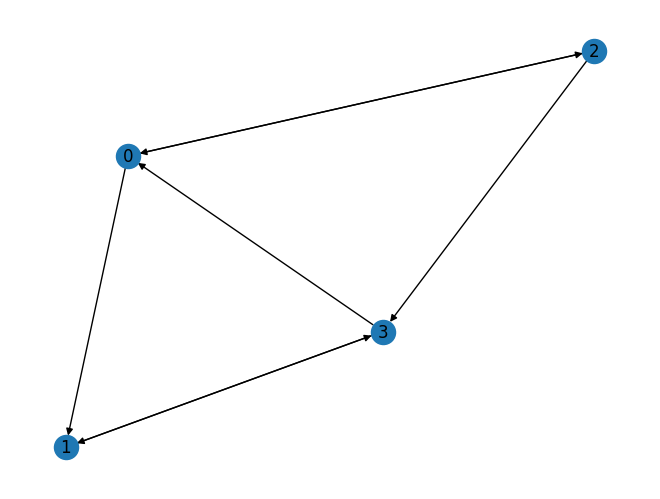

In [58]:
nx.draw(test_dg, with_labels=True)

The `nx.overall_reciprocity` calculates the reciprocity using:

$$r=\frac{L^{\longleftrightarrow}}{L}=\frac{1}{m}*TrA^2$$

however, you can use the following to determine the reciprocity and this is what the function does:

```
n_all_edge = G.number_of_edges()
n_overlap_edge = (n_all_edge - G.to_undirected().number_of_edges()) * 2
return n_overlap_edge / n_all_edge
```

This is clever, it takes all the edges and subtracts the number of edges if the directed graph is not directed. This will give you "(The number of reciprocal links)/2" so you need to multiply by two.

In [59]:
nx.overall_reciprocity(test_dg)

0.5714285714285714

In [56]:
4/7

0.5714285714285714

In [60]:
nx.degree_assortativity_coefficient(test_dg)

-0.16666666666667096

I believe these functions do the same thing...

In [65]:
nx.degree_assortativity_coefficient(dg)

-0.3335568300628826

In [63]:
nx.degree_pearson_correlation_coefficient(dg, weight='weight',x='out',y='in')

-0.06222859801835988